## Ben's Phase 1 Project Notebook

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [270]:
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_crews = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
rt_movies = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [123]:
rt_movies.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [124]:
rt_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [125]:
#Create re_movies_cleaned. Drop 359 movies with no theater date.  Only reduces records with B.O. from 340 to 334.
rt_movies_cleaned = rt_movies.dropna(axis=0, subset=['theater_date'])

In [126]:
#Create new column 'year' for int year.  
rt_movies_cleaned['year'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[-1])

<ipython-input-126-0e6ff07f3c76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movies_cleaned['year'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[-1])


In [127]:
#Remove all movies with no box office records.  Now have 334 records.
rt_movies_cleaned = rt_movies_cleaned.dropna(axis=0, subset=['box_office'])

In [128]:
rt_movies_cleaned.reset_index(inplace=True)

In [129]:
rt_movies_cleaned.drop('index', axis=1)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,year
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2012
1,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures,2002
2,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics,2006
3,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN,2010
4,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",108 minutes,ATO Pictures,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,"25,335,935",119 minutes,Universal Pictures,2005
330,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,"1,416,189",129 minutes,Eros Entertainment,2012
331,1985,A woman who joins the undead against her will ...,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,"Jun 1, 2007","Oct 9, 2007",$,"59,371",98 minutes,IDP Distribution,2007
332,1986,Aki Kaurismaki's The Man Without a Past opens ...,PG,Art House and International|Comedy|Drama,NaN,NaN,"Aug 30, 2002","Oct 7, 2003",$,"794,306",97 minutes,NaN,2002


In [130]:
#Remove commas from B.O. column
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: x.replace(',',''))

In [131]:
rt_movies_cleaned.drop('index', axis=1, inplace=True)

In [132]:
#Convert B.O. to ints
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: int(x))

In [133]:
#Convert years to ints
rt_movies_cleaned.year = rt_movies_cleaned.year.apply(lambda x: int(x))

In [134]:
#Remove all movies before 2000.  Reduces records to 326.
rt_movies_cleaned = rt_movies_cleaned[rt_movies_cleaned.year >= 2000]

In [135]:
#Find movie with rating NC17, then drop the record.  There are 325 records remaining.  
rt_movies_cleaned[rt_movies_cleaned.rating == 'NC17']

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,year
259,1567,Lust is in the air on Harford Road and Sylvia ...,NC17,Comedy,John Waters,John Waters,"Sep 24, 2004","Jun 14, 2005",$,1260219,89 minutes,New Line Cinema,2004


In [136]:
rt_movies_cleaned.drop(259, axis=0, inplace=True)

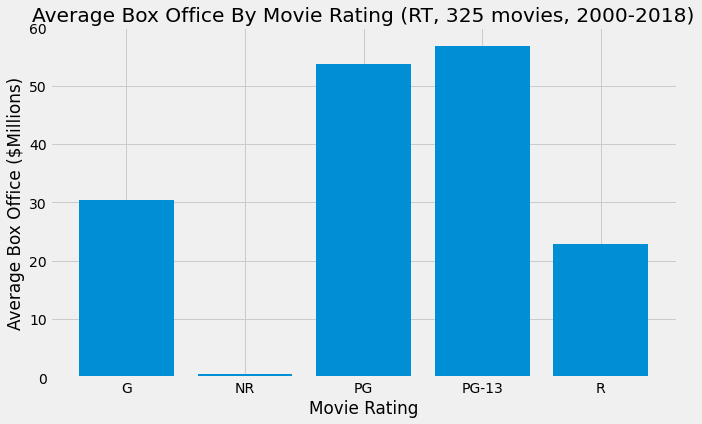

In [166]:
#Rotten Tomatoes db of 325 movies from 2000 to 2018
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('rating').box_office.mean().index
y = rt_movies_cleaned.groupby('rating').box_office.mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Movie Rating (RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

In [138]:
#create a subset of rt_movies_cleaned to remove NaNs from runtime, leaving 323 records
rt_movies_runtime = rt_movies_cleaned.dropna(axis=0, subset=['runtime'])

In [139]:
#create a new column 'minutes' that contains minutes in ints
rt_movies_runtime['minutes'] = rt_movies_runtime.runtime.apply(lambda x: int(x.split()[0]))

<ipython-input-139-e61e71d3d3e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movies_runtime['minutes'] = rt_movies_runtime.runtime.apply(lambda x: int(x.split()[0]))


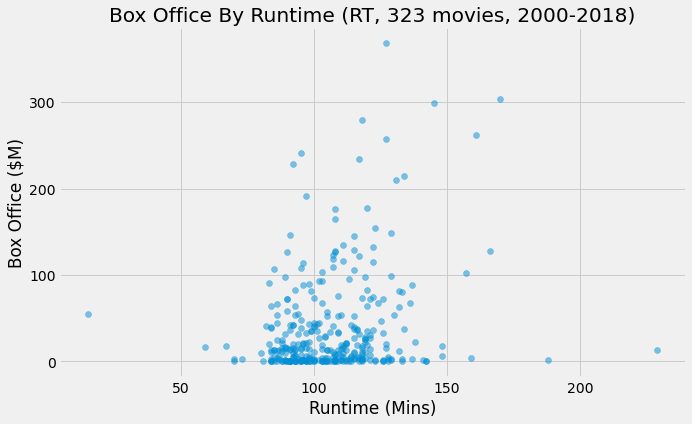

In [165]:
#Scatter plot of B.O. by runtime from RT db with 323 movies from 2000-2018
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(rt_movies_runtime.minutes, rt_movies_runtime.box_office, alpha=.5)
ax.set_xlabel('Runtime (Mins)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office By Runtime (RT, 323 movies, 2000-2018)')
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

In [141]:
#create rt_movies_directors with 286 records by dropping NaNs from rt_movies_cleaned
rt_movies_directors = rt_movies_cleaned.dropna(axis=0, subset=['director'])

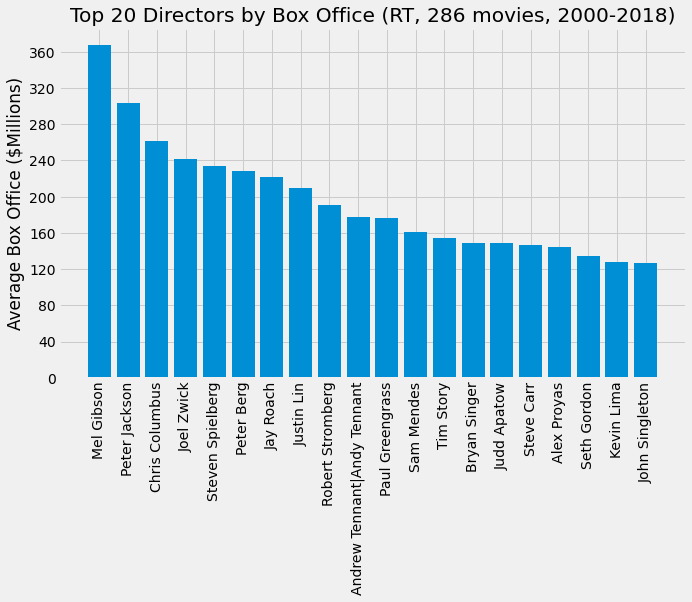

In [164]:
#Plot top 20 directors by mean B.O. Not very informative because most directors have only one movie listed.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].index
y = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Top 20 Directors by Box Office (RT, 286 movies, 2000-2018)')
ax.set_xticks(range(20))
ax.set_xticklabels(x, rotation=90)
ax.set_yticks(range(0,400000000,40000000))
ax.set_yticklabels(range(0,400,40));

In [216]:
rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:20].sort_values()

genre
Action and Adventure|Comedy|Drama                                          6.721190e+07
Action and Adventure|Mystery and Suspense|Romance                          6.763116e+07
Animation|Comedy|Kids and Family                                           6.879599e+07
Action and Adventure|Horror|Kids and Family|Science Fiction and Fantasy    7.305868e+07
Action and Adventure|Mystery and Suspense                                  7.425655e+07
Comedy|Romance                                                             7.487263e+07
Animation|Comedy                                                           9.766183e+07
Action and Adventure|Drama|Mystery and Suspense                            9.772915e+07
Action and Adventure|Comedy|Science Fiction and Fantasy                    9.800000e+07
Action and Adventure|Animation|Comedy|Drama|Kids and Family                1.066043e+08
Action and Adventure|Animation|Comedy                                      1.140536e+08
Action and Adventure|Anima

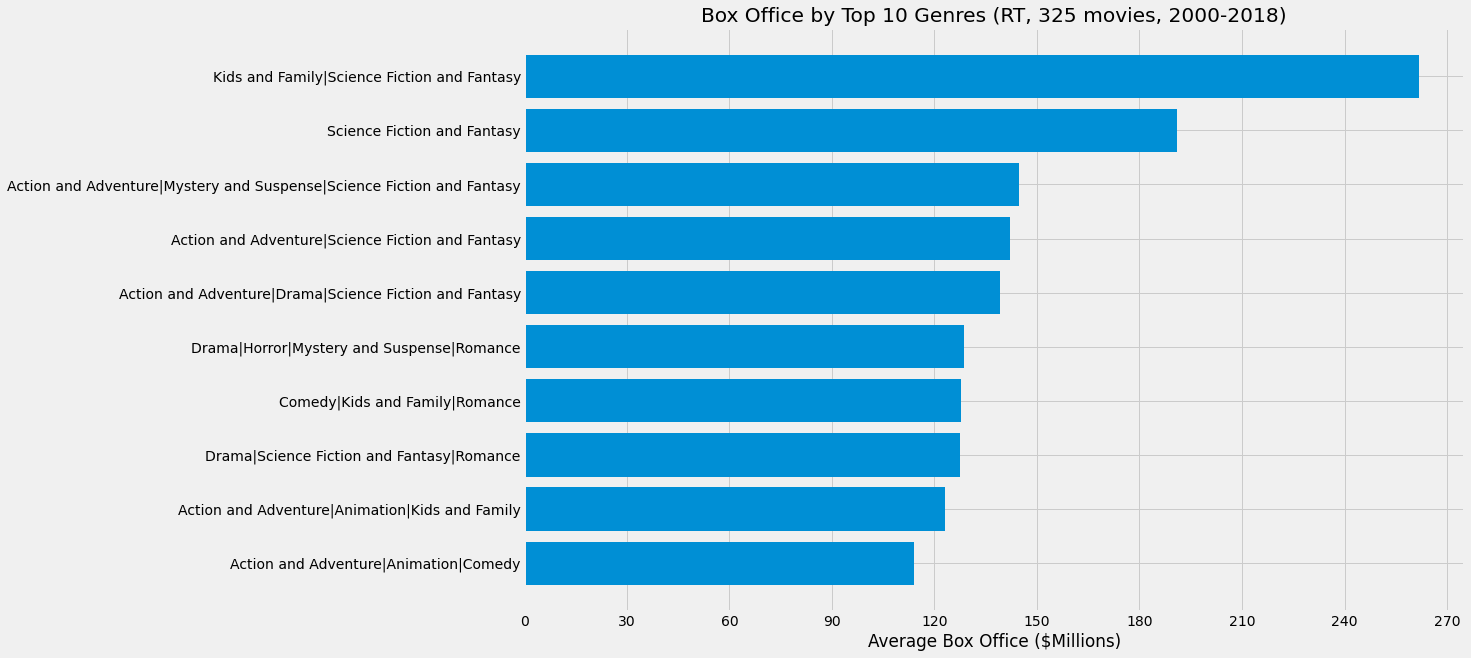

In [217]:
#Create a plot showing top 10 genres by B.O. using rt_movies_cleaned (325 records)
fig, ax = plt.subplots(figsize=(15,10))
x = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().index
y = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Box Office ($Millions)')
ax.set_title('Box Office by Top 10 Genres (RT, 325 movies, 2000-2018)')
ax.set_xticks(range(0,300000000,30000000))
ax.set_xticklabels(range(0,300,30));

In [271]:
rt_reviews.head(20)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
5,3,... Cronenberg's Cosmopolis expresses somethin...,NaN,fresh,Michelle Orange,0,Capital New York,"September 11, 2017"
6,3,"Quickly grows repetitive and tiresome, meander...",C,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
8,3,"Cronenberg's cold, exacting precision and emot...",NaN,fresh,Sean Axmaker,0,Parallax View,"March 24, 2013"
9,3,Over and above its topical urgency or the bit ...,NaN,fresh,Kong Rithdee,0,Bangkok Post,"March 4, 2013"


In [272]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [273]:
#Remove all records where top_critic = 0. Reduces rt_reviews from 54,432 to 13,096 records
rt_reviews = rt_reviews[rt_reviews.top_critic == 1]

In [274]:
#Create new column 'fresh_value' that is 1 for 'fresh' movies or 0 for 'rotten' movies.
rt_reviews['fresh_value'] = rt_reviews.fresh.apply(lambda x: 1 if x == 'fresh' else 0)

In [288]:
#Create a series of the percentage of fresh reviews for each movie id (889 records)
total_reviews = rt_reviews.groupby('id').fresh_value.count()
fresh_reviews = rt_reviews.groupby('id').fresh_value.sum()
fresh_percent = fresh_reviews / total_reviews 

In [297]:
#Create a series of the number of reviews for each movie id (889 records)
num_reviews = rt_reviews.groupby('id').id.count()

In [287]:
#Merege the two series and rename the columns
merge_fresh_and_num_reviews = pd.concat([fresh_percent, num_reviews], axis=1)
merge_fresh_and_num_reviews.rename(columns={'id':'num_reviews'}, inplace=True)

In [298]:
#Remove all records with less than 10 reviews, leaving 447 records.
merge_fresh_and_num_reviews = merge_fresh_and_num_reviews[merge_fresh_and_num_reviews.num_reviews >= 10]

In [299]:
#inner merge rt_movies_cleaned with the series fresh percent into rt_movies_cleaned_reviews (268 records)
rt_movies_cleaned_reviews = rt_movies_cleaned.merge(merge_fresh_and_num_reviews, how='inner', on='id')

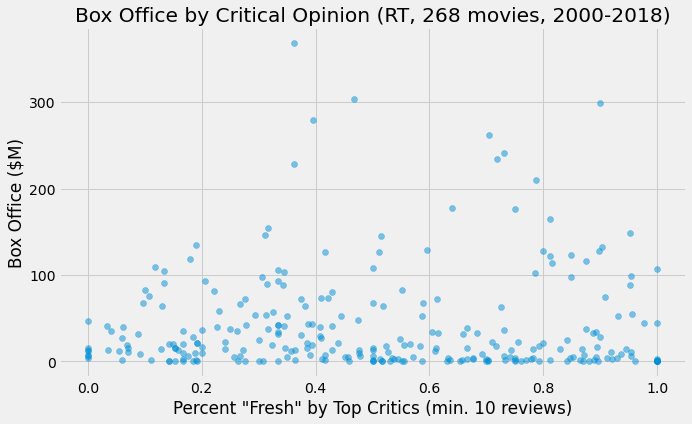

In [306]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(rt_movies_cleaned_reviews.fresh_value, rt_movies_cleaned_reviews.box_office, alpha=.5)
ax.set_xlabel('Percent \"Fresh\" by Top Critics (min. 10 reviews)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office by Critical Opinion (RT, 268 movies, 2000-2018)')
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));